In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
# from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [7]:
def run_data_pipeline(df):
    """
    Data pipeline is outlined by the following process:
        1) Sort the data by last trip date in ascending order
        2) Fill in missing ratings data with the average rating of all riders and drivers respectively
        3) Drop the remaining records that contain any sort of missing values (other than ratings)
        4) Convert last trip date from pandas object to datetime format
        5) Create a "churn" column of Boolean value to determine based on our company standards of active users
        6) Create column in Boolean value if app user's device is an iPhone
        7) Convert luxury car indicator to Boolean
        8) Create dummy variables for city
    """

    df = df.sort_values(by=['last_trip_date'])
    _fill_na_mean(df, 'avg_rating_of_driver')
    _fill_na_mean(df, 'avg_rating_by_driver')
    df.dropna(axis=0, inplace=True)
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    df = _create_indicator(df, 'churn',  df['last_trip_date'] < '2014-06-01')
    df = _create_indicator(df, 'phone', df['phone'] == 'iPhone')
    df['luxury_car_user'] = df['luxury_car_user'] * 1
    df = pd.get_dummies(df, columns=['city'], drop_first=False)

    return df

def create_variables(df):

    X = df.drop(columns = ['signup_date', 'last_trip_date', 'churn'])
    y = df['churn']

    return X,y


def _fill_na_mean(df, column):
    df[column].fillna(df[column].mean(), inplace=True)


def _create_indicator(df, column, condition):
    df[column] = condition
    df[column] = df[column] * 1
    return df

# def predict_model(X_train, y_train, X_test, model, trees = 100):
#     if model == LogisticRegression:
#         model = model(max_iter=1000)
#     else:
#         model = model(n_estimators = trees)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_pred_probs = model.predict_proba(X_test)[:,1]
#     return y_pred, y_pred_probs

def print_metrics(y, y_pred):
    print("Accuracy Score: ", accuracy_score(y, y_pred))
    print("Confusion Matrix: ", confusion_matrix(y, y_pred, labels = [1,0]))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print("Precision Score: ", precision_score(y, y_pred))
    print("Recall Score: ", recall_score(y, y_pred))
    print("")
    return

# ROC Curve
def create_roc_curve(y_test,y_pred_probs1, y_pred_probs2, y_pred_probs3, model1, model2, model3):
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_probs1)
    auc1 = roc_auc_score(y_test, y_pred_probs1)

    fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs2)
    auc2 = roc_auc_score(y_test, y_pred_probs2)

    fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs3)
    auc3 = roc_auc_score(y_test, y_pred_probs3)

    plt.figure(1,figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=f'{model1} AUC={round(auc1,3)}')
    plt.plot(fpr2, tpr2, label=f'{model2} AUC={round(auc2,3)}')
    plt.plot(fpr3, tpr3, label=f'{model3} AUC={round(auc3,3)}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    return

In [8]:
def predict_model(X_train, y_train, X_test, model, trees = 100):
    if model == LogisticRegression:
        model = model(max_iter=1000)
    else:
        model = model(n_estimators = trees)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:,1]
    return y_pred, y_pred_probs, model

In [ ]:
def create_feature_importance_chart(model):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
    plt.title('Feature Importance (MDI)')
    plt.show()

In [9]:
df0_train = pd.read_csv('../data/churn_train.csv')
df0_test = pd.read_csv('../data/churn_test.csv')

In [10]:
df_train = df0_train.copy()
df_test = df0_test.copy()

In [11]:
df_final_train = run_data_pipeline(df_train)

In [12]:
X_train, y_train = create_variables(df_final_train)

In [13]:
df_final_test = run_data_pipeline(df_test)

In [14]:
X_test, y_test = create_variables(df_final_test)

In [15]:
gbc = GradientBoostingClassifier(n_estimators = 100)

In [16]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [17]:
y_pred = gbc.predict(X_test)

In [18]:
y_pred_proba = gbc.predict_proba(X_test)[:,1]

In [19]:
feature_importance = gbc.feature_importances_

In [20]:
print(feature_importance)

[1.67891162e-02 2.38795824e-01 1.17104930e-02 4.31578397e-03
 8.98019031e-02 1.87319895e-01 4.12660451e-02 7.08944132e-02
 1.52771129e-01 2.79927550e-02 1.58337243e-01 5.39978515e-06]


In [ ]:
df = pd.DataFrame(data=feature_importance, index=X_train.columns, columns=["importance"])

In [ ]:
print(df)

In [ ]:
X_test.info()

In [21]:
sorted_idx = np.argsort(feature_importance)

In [22]:
print(sorted_idx)

[11  3  2  0  9  6  7  4  8 10  5  1]


In [ ]:
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')

In [ ]:
plt.yticks(pos, np.array(list(X_train.columns)[sorted_idx]))

In [ ]:
list(X_train.columns)[sorted_idx]

In [ ]:
np.array

In [26]:
np.array(X_train.columns)[sorted_idx]

array(['city_Winterfell', 'avg_surge', 'avg_rating_of_driver', 'avg_dist',
       'city_Astapor', 'trips_in_first_30_days', 'luxury_car_user',
       'phone', 'weekday_pct', "city_King's Landing", 'surge_pct',
       'avg_rating_by_driver'], dtype=object)

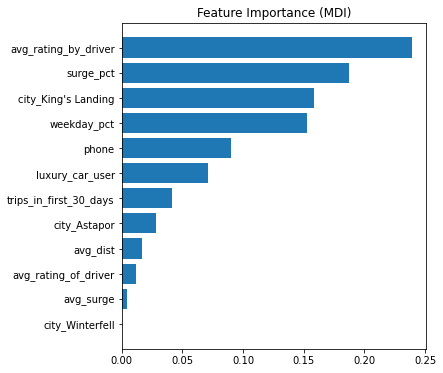

In [28]:
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(X_train.columns))[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

In [2]:
from sklearn import datasets

In [3]:
diabetes = datasets.load_diabetes()

In [5]:
diabetes.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [6]:
diabetes.feature_names[]

list

In [ ]:
y_pred1, y_pred_proba1, lr_model = predict_model(X_train, y_train, X_test, LogisticRegression)
y_pred2, y_pred_proba2, rfc_model  = predict_model(X_train, y_train, X_test, RandomForestClassifier)
y_pred3, y_pred_proba3, gbc_model = predict_model(X_train, y_train, X_test, GradientBoostingClassifier)

In [ ]:
print_metrics(y_test, y_pred1)
print_metrics(y_test, y_pred2)
print_metrics(y_test,y_pred3)
create_roc_curve(y_test,y_pred_proba1, y_pred_proba2,y_pred_proba3,'LR','RF','GB')

In [ ]:
def create_feature_importance_chart(model):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    # plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
    plt.title('Feature Importance (MDI)')

    result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                    random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    # plt.boxplot(result.importances[sorted_idx].T,
    #             vert=False, labels=np.array(diabetes.feature_names)[sorted_idx])
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()

In [ ]:
print(feat3)

In [ ]:
df.head(5).T

In [ ]:
df.head(5)

In [ ]:
#new_df = df['last_trip_date'].sort_values(ascending = False)
new = df.sort_values(by = ['last_trip_date'])

In [ ]:
#new.info()
new['avg_rating_of_driver'].fillna(new['avg_rating_of_driver'].mean(), inplace = True)
new['avg_rating_by_driver'].fillna(new['avg_rating_by_driver'].mean(), inplace = True)

In [ ]:
new.info()

In [ ]:
new.dropna(axis = 0, inplace = True)

In [ ]:
new.info()

In [ ]:
df = new.copy()

In [ ]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [ ]:
df['churn'] = df['last_trip_date'] < '2014-06-01'

In [ ]:
df['churn'] = df['churn'] * 1
df['phone'] = df['phone'] == 'iPhone'
df['phone'] = df['phone'] * 1

In [ ]:
df = pd.get_dummies(df, columns = ['city'], drop_first = False)

In [ ]:
df['luxury_car_user'] = df['luxury_car_user'] * 1

In [ ]:
df.info()

In [ ]:
df.head(10).T

In [ ]:
df['phone'].unique()

In [ ]:
df.head(5).T

In [ ]:

X = df.drop(columns = ['signup_date','last_trip_date','churn'])


In [ ]:
y = df['churn']

In [ ]:
X_train = X

In [ ]:
y_train = y

In [ ]:
log_model = LogisticRegression(max_iter = 1000)
log_model.fit(X_train,y_train)

In [ ]:
y_pred = log_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred, labels = [1,0])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
(tn, fp, fn, tp)

In [ ]:
con_matrix = np.array([[tp, fn], [fp, tn]])

In [ ]:
con_matrix

In [ ]:
log_model.coef_

In [ ]:
coeff = log_model.coef_
ind = (coeff**2).argsort()
labels = [item for item in X.columns]

In [ ]:
fig,ax = plt.subplots()
plt.axhline(y=0,color='red')
plt.plot(np.linspace(0, 11, 12), coeff.T)
ax.set_xticklabels(labels)
plt.xticks(np.linspace(0,11,12), rotation=90);

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
x = np.linspace(0, 11, 12)
markerline, stemlines, baseline = plt.stem(x, coeff.T, '-.')
plt.setp(baseline, color='r', linewidth=2)
plt.xticks(np.linspace(0,11,12), labels,rotation=90)
plt.xlabel('Features')
plt.ylabel('Beta Coefficients')
plt.title('Feature Impact')
plt.grid(linestyle ='--',lw=0.5)
plt.show()

In [ ]:
print(classification_report(y, y_pred))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

In [ ]:
rf_model.feature_importances_

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
# ROC Curve
def create_ROC_curve_plot(y_test,y_pred_probs, model):
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=model)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return 
    

In [ ]:
y_pred, y_pred_probs = model_pred(X_train, y_train, X_test, y_test, RandomForestClassifier)

In [ ]:
y_pred_probs.shape

In [ ]:
ROC_curve_plot(y_test,y_pred_probs, 'RF')

In [ ]:
y_pred, y_pred_probs = model_pred(X_train, y_train, X_test, y_test, LogisticRegression)
ROC_curve_plot(y_test,y_pred_probs, 'LR')

In [ ]:
def ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2, y_pred_probs3, model1, model2, model3):
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_probs1)
    auc1 = roc_auc_score(y_test, y_pred_probs1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs2)
    auc2 = roc_auc_score(y_test, y_pred_probs2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs3)
    auc3 = roc_auc_score(y_test, y_pred_probs3) 
    plt.figure(1,figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=f'{model1} AUC={round(auc1,3)}')
    plt.plot(fpr2, tpr2, label=f'{model2} AUC={round(auc2,3)}')
    plt.plot(fpr3, tpr3, label=f'{model3} AUC={round(auc3,3)}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return 

In [ ]:
y_pred1, y_pred_probs1 = model_pred(X_train, y_train, X_test, y_test, LogisticRegression)
y_pred2, y_pred_probs2 = model_pred(X_train, y_train, X_test, y_test, RandomForestClassifier)
y_pred3, y_pred_probs3 = model_pred(X_train, y_train, X_test, y_test, GradientBoostingClassifier)

In [ ]:
ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2,y_pred_probs3, 'LR', 'RF','GB')

In [ ]:
cost_benefit = np.array([[0, 0], [-0.7, 0.3]]).T
def profit_curve(cost_benefit, predicted_probs, y_test):
    """Function to calculate list of profits based on supplied cost-benefit
    matrix and prediced probabilities of data points and thier true labels.
    Parameters
    ----------
    cost_benefit    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TP | FP |
                                          -----------
                                          | FN | TN |
                                          -----------
    predicted_probs : ndarray - 1D, predicted probability for each datapoint
                                    in labels, in range [0, 1]
    labels          : ndarray - 1D, true label of datapoints, 0 or 1
    Returns
    -------
    profits    : ndarray - 1D
    thresholds : ndarray - 1D
    """
    n_obs = float(len(y_test))
    # Make sure that 1 is going to be one of our thresholds
    maybe_one = [] if 1 in predicted_probs else [1] 
    all_thresholds = maybe_one + sorted(predicted_probs, reverse=True)
    thresholds = all_thresholds[::50]
    profits = []
    for threshold in thresholds:
        y_predict = predicted_probs >= threshold
        confusion_matrix_ = confusion_matrix(y_test, y_predict, labels = [1,0])
        threshold_profit = np.sum(confusion_matrix_ * cost_benefit) / n_obs
        profits.append(threshold_profit)
    return np.array(profits), np.array(thresholds)

In [ ]:

def get_model_profits(model, cost_benefit, X_train, X_test, y_train, y_test):
    """Fits passed model on training data and calculates profit from cost-benefit
    matrix at each probability threshold.
    Parameters
    ----------
    model           : sklearn model - need to implement fit and predict
    cost_benefit    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TP | FP |
                                          -----------
                                          | FN | TN |
                                          -----------
    X_train         : ndarray - 2D
    X_test          : ndarray - 2D
    y_train         : ndarray - 1D
    y_test          : ndarray - 1D
    Returns
    -------
    model_profits : model, profits, thresholds
    """
    model.fit(X_train, y_train)
    predicted_probs = model.predict_proba(X_test)[:, 1]
    profits, thresholds = profit_curve(cost_benefit, predicted_probs, y_test)

    return profits, thresholds

In [ ]:
profs, thrs = profit_curve(cost_benefit, y_pred_probs3, y_test)

In [ ]:
max_thr = thrs[np.argmax(profs)]
max_thr

In [ ]:
max_profs = np.max(profs)


In [ ]:
max_profs

In [ ]:
new_model = GradientBoostingClassifier()
new_model.fit(X_train, y_train)
#print(" done.")

#print('Convenience plot with ``partial_dependence_plots``')

features = [4,7,9,10]
fig, axs = plot_partial_dependence(new_model, X_train, features,figsize = (10, 10), 
                                   feature_names= [item for item in X.columns],
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence plots')
plt.subplots_adjust(top=0.9, bottom = 0.2, wspace = 0.5)  # tight_layout causes overlap with suptitle

#print('Custom 3d plot via ``partial_dependence``')
#fig = plt.figure()
